Importing libraries

In [1]:
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import twitter_samples 
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [2]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json') 
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

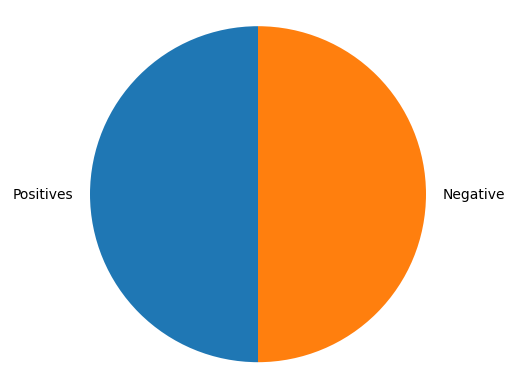

In [3]:
fig = plt.figure()

labels = 'Positives', 'Negative'

sizes = [len(all_positive_tweets), len(all_negative_tweets)] 
plt.pie(sizes, labels=labels,  startangle=90)
plt.axis('equal')  
plt.show()

In [4]:
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)))
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)))

In [5]:
def process_tweet(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  
                word not in string.punctuation):  
            stem_word = stemmer.stem(word)  
            tweets_clean.append(stem_word)

    return tweets_clean

In [6]:
print("Before preprocessing")
print(all_positive_tweets[0])
print("After preprocessing")
res=process_tweet(all_positive_tweets[0])
print(res)

Before preprocessing
#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
After preprocessing
['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']


In [7]:
def build_freqs(tweets, ys):
    yslist = np.squeeze(ys).tolist()
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [8]:
freqs = build_freqs(train_x, train_y)

In [9]:
def extract_features(tweet, freqs):
    word_l = process_tweet(tweet)
    x = np.zeros((1, 3)) 
    x[0,0] = 1 
    for word in word_l:
        x[0,1] += freqs.get((word, 1.0),0)
        x[0,2] += freqs.get((word, 0.0),0)
         
    assert(x.shape == (1, 3))
    return x

In [10]:
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)
Y = train_y
model = LogisticRegression()
model.fit(X,Y)

LogisticRegression()

In [11]:
Y = np.zeros((len(test_x), 3))
for i in range(len(test_x)):
    Y[i, :]= extract_features(test_x[i], freqs)
pred_y=model.predict(Y)
accuracy = accuracy_score(test_y, pred_y)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 99.15%


In [12]:
print(model.predict(extract_features("the sky looks fresh",freqs)))

[1.]
